<img src="OC.png" width="50" height="50" align="left">    

***

<center> <font size="6"> <span style='color:Blue'> P5: Segmentez des clients d'un site e-commerce </span></font> </center>  

***

**Contexte**  
**Olist** est une entreprise brésilienne qui propose une solution de vente sue les marketplaces en ligne.
<img src="Olist.jpeg">
**Mission**   
Fournir à l'équipe marketing:  
* **une segmentation des clients** qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.  
* **une description actionable** de la segmentation et de sa logique sous-jacente pour une utilisation optimale.
* **une proposition de contrat de maintenance** basée sur une analyse de la stabilité des segments au cours du temps.

 <font size="4"> <span style="font-size: 1.5em" > **Partie 3: Simulation** </span> </font> 

Ce notebook sera dédié au contrat de maintenance. L'objectif est de faire une recommandation de fréquence à laquelle la segmentation doit être mise à jour pour rester pertinente, afin de pouvoir effectuer un devis de contrat de maintenance. Il s'agit de préciser une période de maintenance au bout de la quelle, l'algorithme doit être ré-étudié vu qu'il commence à perdre ses performances suite aux changements du jeu de données d'entrée.

On entraîne:
* un modèle M0 pour toutes les données jusqu'à un temps t0 (ici un an du 04/09/2016 au 03/03/2018).
* un modèle Mi qui prend en compte les données jusqu'à après i semaines ti = t0 + 7i, (t en jours).   

Ensuite, on utilise les deux modèles pour faire la prédiction sur tous les clients jusqu'à la date ti. Quand l'ARI score descend sous une certaine valeur seuil=0.8, l'abscisse correspond donc au délai de maintenance.

La standardisation pour le modèle M0 ne sera pas la même que pour le modèle Mi, donc quand on prédit avec M0 sur les données à t1, on utilise bien le standard scaler du modèle M0, et si on prédit avec M1, on utilise le standar scaler du modèle M1, etc.. 

Les étapes de cette démarche consistent en:

* Le chargement du jeu de données nettoyé sur les commandes.
* 
* La selection de données afin de considérer que les données entre une date d'entrée et une date de sortie.
* La standardisation des variables numériques: c'est une étape qui va se répéter à chaque itération.
* Le score ARI est calculé entre les valeurs prédites avec le modèle M0 (année 1) et les valeurs considérées réelles prédites à patir d'un nouveau modèle Mi.

# 

## Importation des librairies Python pour DS

In [1]:
%load_ext pycodestyle_magic
%flake8_on 

In [21]:
# ------------------------------------------
# projet : données des clients Olist
# Auteur : Rim BAHROUN
# Date: Janvier 2023
# OpenClassrooms
# Notebook: 3/3
# -------------------------------------------
# importation des librairies Python pour DS
# -------------------------------------------
import numpy as np
import pandas as pd
import csv

import datetime as dt
from datetime import timedelta

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

from shapely.geometry import LineString

import warnings

In [3]:
# pour afficher 165 colonnes ou lignes minimum
pd.set_option('display.max_column', 100)
pd.set_option('display.max_row', 100)

## Fonctions utilent

In [4]:
def donnees_jusqua_t(ti, data_orders):
    '''
    Fonction qui renvoie le dataframe X_i avec les données des clients
    jusqu'à la date ti à partir du data_orders.
    '''
    data_orders_i = data_orders.loc[data_orders['date_commande'] < ti, :]

    # calcul de la récence = date_reference - date de commande
    date_reference_i = data_orders_i["date_commande"].dt\
        .date.sort_values().iloc[-1] + timedelta(days=1)
    data_orders_i['order_recency_days'] = data_orders_i[
        "date_commande"].dt.date.apply(
        lambda x: date_reference_i - x).dt.days

    # Données clients avec 7 variables jusqu'à la date ti = t0 + i*7days
    X_i = data_orders_i.groupby('customer_unique_id').agg(
        # nbre de jours depuis la dernière commande
        recency=("order_recency_days", 'min'),
        # nombre de commandes par client
        frequency=("order_id", 'count'),
        # somme des payements
        monetory=("payment_value", 'sum'),
        # moyenne des scores donnés par le client
        avis=("review_score", lambda x: round(x.mean())),
        # nbre de jours moyen de livraison
        nbr_jour_livraison=("order_delivery_time_days",
                            lambda x: round(x.mean())),
        # moyenne des nombres de versements
        nbr_versement_moyen=("payment_installments",
                             lambda x: round(x.mean())),
        # nombre d'articles achetés
        nbr_total_article=("order_item_number",
                           lambda x: round(x.sum())))
    return X_i

In [5]:
def plot_ari_score(seuil, ari_score):

    # Find the intersection point between ari-score and the threeshold
    x = ari_score.periode_semaines.values
    y1 = ari_score.ari_score.values
    line_1 = LineString(np.column_stack((x, y1)))
    y2 = seuil*np.ones(len(x))
    line_2 = LineString(np.column_stack((x, y2)))
    intersection = line_1.intersection(line_2)
    x_intersection, y_intersection = intersection.xy
    x_intersection = x_intersection[0]
    y_intersection = y_intersection[0]

    nbr_semaine_maintenance = round(x_intersection)

    print('La période à partir de laquelle il faut ré-entrainer '
          + 'le modèle est de {} semaines (soit {} jours)'
          .format(nbr_semaine_maintenance, round(7*x_intersection)))

    plt.figure(figsize=(10, 6))
    # Drawing ARI Score
    sns.lineplot(data=ari_score,
                 x="periode_semaines",
                 y="ari_score")
    plt.xlabel("Période (en semaine)")
    plt.ylabel("ARI-score")
    plt.title("Stabilité temporelle de la segmentation par K-Means",
              fontsize=18,
              color="m")
    plt.xlim(0, 20)
    plt.ylim(0, 1)

    plt.plot(x_intersection, y_intersection, 'ro')

    # Drawing a horizontal line at point seuil
    plt.axhline(y=seuil,
                xmin=0,
                xmax=0.57,
                linestyle="--",
                color="m")

    # Drawing a vertical line at the intersection
    plt.axvline(x=x_intersection,
                ymin=0,
                ymax=seuil,
                linestyle="--",
                color="m",
                alpha=0.6)
    plt.grid(visible=True)
    plt.yticks(np.arange(0, 1, step=0.1))
    plt.xticks(np.arange(20))
    plt.show()
    return nbr_semaine_maintenance

## Importation des données

In [6]:
# importation des données
olist_orders = pd.read_csv('olist_orders_features7.csv')

In [7]:
olist_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98199 entries, 0 to 98198
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        98199 non-null  object 
 1   order_id                  98199 non-null  object 
 2   payment_value             98199 non-null  float64
 3   review_score              98199 non-null  float64
 4   order_delivery_time_days  98199 non-null  int64  
 5   payment_installments      98199 non-null  float64
 6   order_item_number         98199 non-null  float64
 7   order_purchase_timestamp  98199 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 6.0+ MB


In [8]:
olist_orders['review_score'] = olist_orders[
    'review_score'].astype(int)
olist_orders['payment_installments'] = olist_orders[
    'payment_installments'].astype(int)
olist_orders['order_item_number'] = olist_orders[
    'order_item_number'].astype(int)

In [9]:
olist_orders.rename(columns={"order_purchase_timestamp": "date_commande"},
                    inplace=True)

In [10]:
olist_orders["date_commande"] = olist_orders["date_commande"].apply(
    pd.to_datetime)

In [11]:
olist_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98199 entries, 0 to 98198
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_unique_id        98199 non-null  object        
 1   order_id                  98199 non-null  object        
 2   payment_value             98199 non-null  float64       
 3   review_score              98199 non-null  int32         
 4   order_delivery_time_days  98199 non-null  int64         
 5   payment_installments      98199 non-null  int32         
 6   order_item_number         98199 non-null  int32         
 7   date_commande             98199 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int32(3), int64(1), object(2)
memory usage: 4.9+ MB


In [12]:
print(olist_orders.shape)
olist_orders.head()

(98199, 8)


,customer_unique_id,order_id,payment_value,review_score,order_delivery_time_days,payment_installments,order_item_number,date_commande
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,146.87,4,9,2,1,2017-05-16
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,335.48,5,17,8,1,2018-01-12
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,157.73,5,26,7,1,2018-05-19
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,173.30,5,15,1,1,2018-03-13
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,252.25,5,11,8,1,2018-07-29


In [13]:
olist_orders.sort_values('date_commande',
                         ascending=True,
                         inplace=True)
olist_orders.reset_index(drop=True, inplace=True)

In [14]:
olist_orders

,customer_unique_id,order_id,payment_value,review_score,order_delivery_time_days,payment_installments,order_item_number,date_commande
0,b7d76e111c89f7ebf14761390f0f7d17,2e7a8482f6fb09756ca50c10d7bfc047,136.23,1,46,1,2,2016-09-04
1,830d5b7aaa3b6f1e9ad63703bec97d23,bfbd0f9bdef84302105ad712db648a6c,143.46,1,55,1,3,2016-09-15
2,2f64e403852e6893ae37485d5fcacdaf,be5bc2f0da14d8071e2d45451ad119d9,39.09,4,24,1,1,2016-10-03
3,61db744d2f835035a5625b59350c6b63,a41c8759fbe7aab36ea07e038b2d4465,53.73,3,31,1,1,2016-10-03
4,10e89fd8e5c745f81bec101207ba4d7d,ef1b29b591d31d57c0d7337460dd83c9,92.27,1,29,3,1,2016-10-03
...,...,...,...,...,...,...,...,...
98194,5c58de6fb80e93396e2f35642666b693,0b223d92c27432930dfe407c6aea3041,510.96,5,1,8,2,2018-08-29
98195,7febafa06d9d8f232a900a2937f04338,168626408cb32af0ffaf76711caae1dc,61.29,5,1,1,1,2018-08-29
98196,21dbe8eabd00b34492a939c540e2b1a7,d70442bc5e3cb7438da497cc6a210f80,14.29,5,1,1,1,2018-08-29
98197,0c6d7218d5f3fa14514fd29865269993,912859fef5a0bd5059b6d48fa79d121a,178.25,5,1,1,1,2018-08-29


In [15]:
data_orders = olist_orders.copy()
data_orders.shape

(98199, 8)

# Modèle M0

In [16]:
# t0 est la date à partir de quelle on commence l'étude de la maintenance
# t0 est la date jusqu'à la quelle le modèle M0 est entrainé
t0 = dt.datetime(2018, 3, 3)

In [17]:
warnings.filterwarnings("ignore")
# X_0 données clients jusqu'à la date t0
X_0 = donnees_jusqua_t(t0, data_orders)

In [18]:
X_0.head()

,recency,frequency,monetory,avis,nbr_jour_livraison,nbr_versement_moyen,nbr_total_article
customer_unique_id,,,,,,,
0000f46a3911fa3c0805444483337064,358,1,86.22,3,26,8,1
0000f6ccb0745a6a4b88665a16c9f078,142,1,43.62,4,20,4,1
0004aac84e0df4da2b147fca70cf8255,109,1,196.89,5,13,6,1
00053a61a98854899e70ed204dd4bafe,3,1,419.18,1,16,3,2
0005e1862207bf6ccc02e4228effd9a0,364,1,150.12,4,5,3,1


In [22]:
X_0.shape

(57140, 7)

In [31]:
# create pipeline object
pca_0 = PCA(n_components=5).fit(X_0)
model_0 = Pipeline(steps=[('std', StandardScaler()),
                          ('kmeans', KMeans(init=pca_0.components_,
                                            n_clusters=5,
                                            n_init=1))])

In [24]:
# fit the pipeline to the data
model_0.fit(X_0)

Pipeline(steps=[('std', StandardScaler()),
                ('kmeans',
                 KMeans(init=array([[ 1.07369411e-02,  1.05176663e-04,  9.99929211e-01,
        -2.60259239e-04,  3.33195124e-03,  3.83704527e-03,
         6.21824305e-04],
       [ 9.99910969e-01, -5.18627599e-05, -1.07146778e-02,
         6.54724603e-04, -7.84482009e-03,  1.12509024e-03,
        -1.10194659e-04],
       [ 7.82166447e-03, -4.25326409e-04, -3.45038417e-03,
        -4.60821685e-02,  9.98873883e-01,  7.09487528e-03,
        -1.94884500e-03],
       [ 1.22028981e-03,  4.12312114e-04,  3.80073681e-03,
         4.66296837e-03,  7.32165419e-03, -9.99954264e-01,
         1.20063128e-04],
       [-3.05299057e-04, -1.92225459e-03,  1.35906201e-04,
         9.96339551e-01,  4.57915253e-02,  4.97210538e-03,
        -7.19868538e-02]]),
                        n_clusters=5, n_init=1))])

# Etude de la stabilité temporelle

In [27]:
warnings.filterwarnings("ignore")

ari_score_ = []
# Etude de la stabilité sur 20 périodes de 1 semaine soit 5 mois
for i in range(0, 20):

    # Données jusqu'à la date ti = t0 + i*7days
    ti = t0 + i*timedelta(days=7)
    X_i = donnees_jusqua_t(ti, data_orders)

    # create pipeline object
    pca = PCA(n_components=5).fit(X_i)
    model = Pipeline(steps=[('std', StandardScaler()),
                            ('kmeans', KMeans(init=pca.components_,
                                              n_clusters=5,
                                              n_init=1))])
    
    # fit the pipeline to the data ti pour le model Mi
    model.fit(X_i)

    # use the up dated model to predict the cluster labels
    clusters = model.predict(X_i)
    # use the model_0 to predict the cluster labels
    clusters_0 = model_0.predict(X_i)

    # Calcul du ARI score
    ari = adjusted_rand_score(clusters_0, clusters)
    ari_score_.append([i, ari])

ari_score = pd.DataFrame(ari_score_, columns=["periode_semaines", "ari_score"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


15:80: E501 line too long (94 > 79 characters)
16:1: W293 blank line contains whitespace


In [28]:
ari_score

,periode_semaines,ari_score
0,0,1.000000
1,1,0.971950
2,2,0.947145
3,3,0.934556
4,4,0.920369
5,5,0.908815
6,6,0.887402
7,7,0.865911
8,8,0.854851
9,9,0.842732


La période à partir de laquelle il faut ré-entrainer le modèle est de 11 semaines (soit 80 jours)


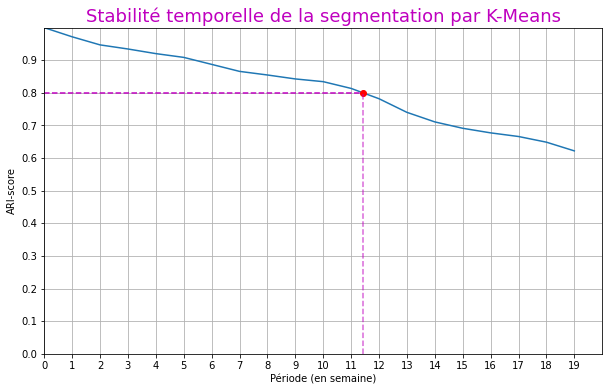

In [29]:
nbr_semaine_maintenance = plot_ari_score(seuil=0.8, ari_score=ari_score)

# Conclusion

Le score ARI mesure la similarité entre les clusters créés, s'il est à 1, le modèle est stable indépendamment des données. Dans notre cas de figure, si le seuil est fixé à 0.8 alors il faut 37 jours pour mettre à jour le modèle afin de correctement classifier les clients dans les clusters les plus correspondants.